In [1]:
import numpy as np
import pandas as pd

In [2]:
import json

with open('compounds.json', 'r') as file:
    string_compounds = json.load(file)
    compounds = {int(k): v for k, v in string_compounds.items()}
    del string_compounds

In [3]:
from rdkit import Chem

In [4]:
arc = pd.DataFrame(index=pd.read_csv('arc_dataset.csv', index_col=0).index)
arc['smiles'] = [compounds[cid]['isomeric_smiles'] for cid in arc.index]
arc['heavy_atom_count'] = [compounds[cid]['heavy_atom_count'] for cid in arc.index]
arc['molecule'] = [Chem.MolFromSmiles(smiles) for smiles in arc['smiles']]
arc

,smiles,heavy_atom_count,molecule
107,C1=CC=C(C=C1)CCC(=O)O,11,<rdkit.Chem.rdchem.Mol object at 0x16bd338b0>
126,C1=CC(=CC=C1C=O)O,9,<rdkit.Chem.rdchem.Mol object at 0x16bd33840>
174,C(CO)O,4,<rdkit.Chem.rdchem.Mol object at 0x16bd33920>
177,CC=O,3,<rdkit.Chem.rdchem.Mol object at 0x16bd33990>
179,CC(C(=O)C)O,6,<rdkit.Chem.rdchem.Mol object at 0x16bd33a00>
...,...,...,...
143411647,CC.C=CC1=CC=C(C=C1)C=O,12,<rdkit.Chem.rdchem.Mol object at 0x16c2e1620>
143963103,CC1=C(C=C(C=C1C(C)C)C=O)C(C)C,15,<rdkit.Chem.rdchem.Mol object at 0x16c2e1690>
144116082,CCC(=O)C1(CCC(CC1)C(C)C)C,14,<rdkit.Chem.rdchem.Mol object at 0x16c2e1700>
145793235,CC(C)CCC(=CCCC(=CC=O)C)C,15,<rdkit.Chem.rdchem.Mol object at 0x16c2e1770>


In [5]:
import networkx as nx

def create_molecule_graph(df, molecule_column):
    """
    Create a networkx graph of parent-child molecules from a dataframe.

    Parameters:
        df (pandas.DataFrame): The dataframe containing the molecules.
        molecule_column (str): The name of the column containing Chem.molecules.

    Returns:
        nx.DiGraph: The directed graph of parent-child molecules.
    """
    # Create an empty directed graph
    G = nx.DiGraph()

    # Iterate through each row in the dataframe
    for idx, row in df.iterrows():
        molecule = row[molecule_column]

        # Add molecule node to the graph
        G.add_node(idx, molecule=molecule)

        # Iterate through previous rows to find parent molecules
        for prev_idx, prev_row in df.loc[:idx-1].iterrows():
            child_molecule = prev_row[molecule_column]

            # Check if the current molecule is a submolecule of the parent molecule
            if is_submolecule(molecule, child_molecule):
                # Add edge from parent to child molecule
                G.add_edge(idx, prev_idx)

    return G

def is_submolecule(molecule, child_molecule):
    """
    Check if a molecule is a submolecule of another molecule.

    Parameters:
        molecule (rdkit.Chem.Mol): The molecule to check.
        child_molecule (rdkit.Chem.Mol): The parent molecule to check against.

    Returns:
        bool: True if the molecule is a submolecule of the parent molecule, False otherwise.
    """
    # Check if the SMARTS pattern of the molecule is a substructure of the parent molecule
    return child_molecule.HasSubstructMatch(molecule)

# Example usage:
# Assume you have a dataframe df with a column 'Chem.molecules' containing RDKit molecules

# Create a networkx graph
graph = create_molecule_graph(arc, 'molecule')

# You can now use networkx functions to analyze or visualize the graph


In [6]:
arc['child_molecules'] = [v for k, v in graph.out_degree]
arc['heavy_atom_count'].corr(arc['child_molecules'])

-0.19460300200124983

/var/folders/zp/1226jyvd1ws1q507lfnb8kmm0000gn/T/ipykernel_46356/2671954055.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Heavy Atom Count')


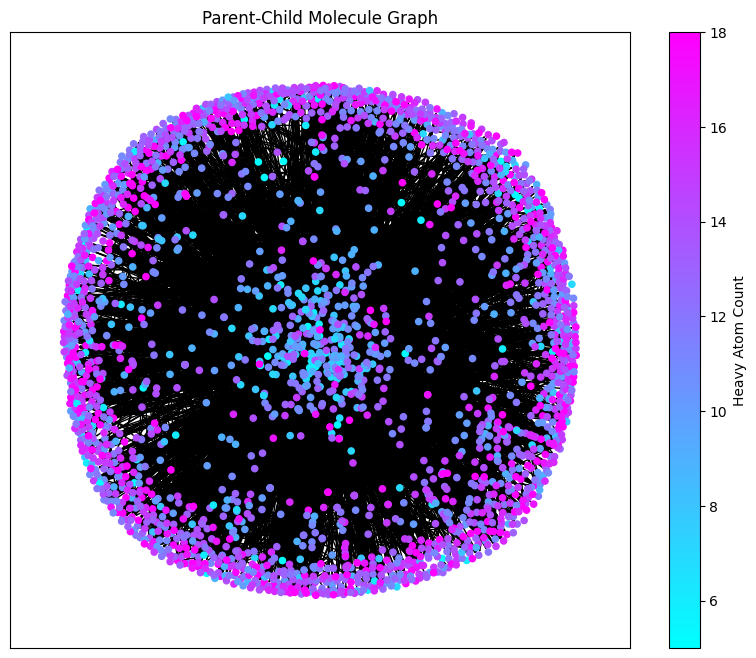

In [7]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

# Assuming you already have the 'graph' variable containing the networkx graph

# Draw the graph
pos = nx.spring_layout(graph)  # Layout algorithm for positioning nodes

color_clip = [5,18]

plt.figure(figsize=(10, 8))
nx.draw_networkx(graph, pos, with_labels=False, node_size=20, node_color=arc['heavy_atom_count'].clip(*color_clip), cmap=plt.cm.cool, arrowsize=1)
plt.title("Parent-Child Molecule Graph")

sm = ScalarMappable(cmap=plt.cm.cool)
sm.set_array(color_clip)

# Add colorbar
plt.colorbar(sm, label='Heavy Atom Count')

plt.show()

In [8]:
graph_cids = list(graph.nodes)
new_nodes = range(len(graph_cids))
mapping = dict(zip(graph_cids, new_nodes))
graph = nx.relabel_nodes(graph, mapping)

In [147]:
import random

import torch
from torch.utils.data import DataLoader, Dataset


class MoleculeEmbeddingDataset(Dataset):
    def __init__(
        self,
        molecules: nx.DiGraph,
    ):
        super().__init__()
        self.molecules = molecules
        self.edges_list = list(molecules.edges())

    # This Dataset object has a sample for each edge in the graph.
    def __len__(self) -> int:
        return len(self.edges_list)

    def __getitem__(self, idx: int):
        # For each existing edge in the graph we choose 10 fake or negative edges, which we build
        # from the idx-th existing edge. So, first we grab this edge from the graph.
        rel = self.edges_list[idx]

        # Next, we take our source node rel[0] and see which nodes in the graph are not a child of
        # this node.
        negative_target_nodes = list(
            self.molecules.nodes() - nx.descendants(self.molecules, rel[0]) - {rel[0]}
        )

        # Then, we sample at most 5 of these negative target nodes...
        negative_target_sample_size = min(5, len(negative_target_nodes))
        negative_target_nodes_sample = random.sample(
            negative_target_nodes, negative_target_sample_size
        )

        # and add these to a tensor which will be used as input for our embedding model.
        edges = torch.tensor([rel] + [[rel[0], neg] for neg in negative_target_nodes_sample])

        # Next, we do the same with our target node rel[1], but now where we sample from nodes
        # which aren't a parent of it.
        negative_source_nodes = list(
            self.molecules.nodes() - nx.ancestors(self.molecules, rel[1]) - {rel[1]}
        )

        # We sample from these negative source nodes until we have a total of 10 negative edges...
        negative_source_sample_size = 10 - negative_target_sample_size
        negative_source_nodes_sample = random.sample(
            negative_source_nodes, negative_source_sample_size
        )

        # and add these to the tensor that we created above.
        edges = torch.cat(
            tensors=(edges, torch.tensor([[neg, rel[1]] for neg in negative_source_nodes_sample])),
            dim=0,
        )

        # Lastly, we create a tensor containing the labels of the edges, indicating whether it's a
        # True or a False edge.
        edge_label_targets = torch.cat(tensors=[torch.ones(1).bool(), torch.zeros(10).bool()])

        return edges, edge_label_targets


# Now, we construct the dataset.
dataset = MoleculeEmbeddingDataset(
    molecules=graph,
)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [148]:
from hypll.manifolds.poincare_ball import Curvature, PoincareBall

poincare_ball = PoincareBall(Curvature(-1))

In [153]:
import hypll.nn as hnn


class PoincareEmbedding(hnn.HEmbedding):
    def __init__(
        self,
        num_embeddings: int,
        embedding_dim: int,
        manifold: PoincareBall,
    ):
        super().__init__(num_embeddings, embedding_dim, manifold)

    # The model outputs the distances between the nodes involved in the input edges as these are
    # used to compute the loss.
    def forward(self, edges: torch.Tensor) -> torch.Tensor:
        embeddings = super().forward(edges)
        edge_distances = self.manifold.dist(x=embeddings[:, :, 0, :], y=embeddings[:, :, 1, :])
        return edge_distances

dims = [2,3]
# We want to embed every node into a n-dimensional Poincare ball.
models = [PoincareEmbedding(
    num_embeddings=len(graph.nodes()),
    embedding_dim=dim,
    manifold=poincare_ball,
) for dim in dims]

In [154]:
# This function is given in equation (5) of the Poincare Embeddings paper.
def poincare_embeddings_loss(dists: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    logits = dists.neg().exp()
    numerator = torch.where(condition=targets, input=logits, other=0).sum(dim=-1)
    denominator = logits.sum(dim=-1)
    loss = (numerator / denominator).log().mean().neg()
    return loss

In [155]:
from hypll.optim import RiemannianSGD

saved_weights = [[],[]]
for i, model in enumerate(models):
    print(f'\nTraining Embedding:')
    print(f'Dimensions = {dims[i]}')
    # The learning rate of 0.3 is dived by 10 during burn-in.
    optimizer = RiemannianSGD(
        params=model.parameters(),
        lr=0.3 / 10,
    )

    # Perform training as we would usually.
    for epoch in range(10):
        average_loss = 0
        for idx, (edges, edge_label_targets) in enumerate(dataloader):
            optimizer.zero_grad()

            dists = model(edges)
            loss = poincare_embeddings_loss(dists=dists, targets=edge_label_targets)
            loss.backward()
            optimizer.step()

            average_loss += loss

        average_loss /= len(dataloader)
        print(f"Burn-in epoch {epoch} loss: {average_loss}")


    # Now we use the actual learning rate 0.3.
    optimizer = RiemannianSGD(
        params=model.parameters(),
        lr=0.3,
    )

    for epoch in range(1000):
        average_loss = 0
        for idx, (edges, edge_label_targets) in enumerate(dataloader):
            optimizer.zero_grad()

            dists = model(edges)
            loss = poincare_embeddings_loss(dists=dists, targets=edge_label_targets)
            loss.backward()
            optimizer.step()

            average_loss += loss

        average_loss /= len(dataloader)
        print(f"Epoch {epoch} loss: {average_loss}")
        if epoch % 100 == 99:
            print('save above epoch')
            saved_weights[i].append(model.weight)


Training Embedding:
Dimensions = 2
Burn-in epoch 0 loss: 3.354379177093506
Burn-in epoch 1 loss: 3.320359706878662
Burn-in epoch 2 loss: 3.2834744453430176
Burn-in epoch 3 loss: 3.248330593109131
Burn-in epoch 4 loss: 3.2369585037231445
Burn-in epoch 5 loss: 3.2036523818969727
Burn-in epoch 6 loss: 3.175071954727173
Burn-in epoch 7 loss: 3.1548988819122314
Burn-in epoch 8 loss: 3.133878707885742
Burn-in epoch 9 loss: 3.111812114715576
Epoch 0 loss: 3.0179333686828613
Epoch 1 loss: 2.8663644790649414
Epoch 2 loss: 2.7308008670806885
Epoch 3 loss: 2.624518394470215
Epoch 4 loss: 2.5195350646972656
Epoch 5 loss: 2.4339823722839355
Epoch 6 loss: 2.361349582672119
Epoch 7 loss: 2.2927753925323486
Epoch 8 loss: 2.238361120223999
Epoch 9 loss: 2.171436071395874
Epoch 10 loss: 2.1236605644226074
Epoch 11 loss: 2.082289934158325
Epoch 12 loss: 2.0375123023986816
Epoch 13 loss: 1.99873685836792
Epoch 14 loss: 1.9685790538787842
Epoch 15 loss: 1.9350594282150269
Epoch 16 loss: 1.903495192527771


In [156]:
for model in models:
    print(model.weight.tensor.max())

tensor(1.7597, grad_fn=<MaxBackward1>)
tensor(1.7593, grad_fn=<MaxBackward1>)


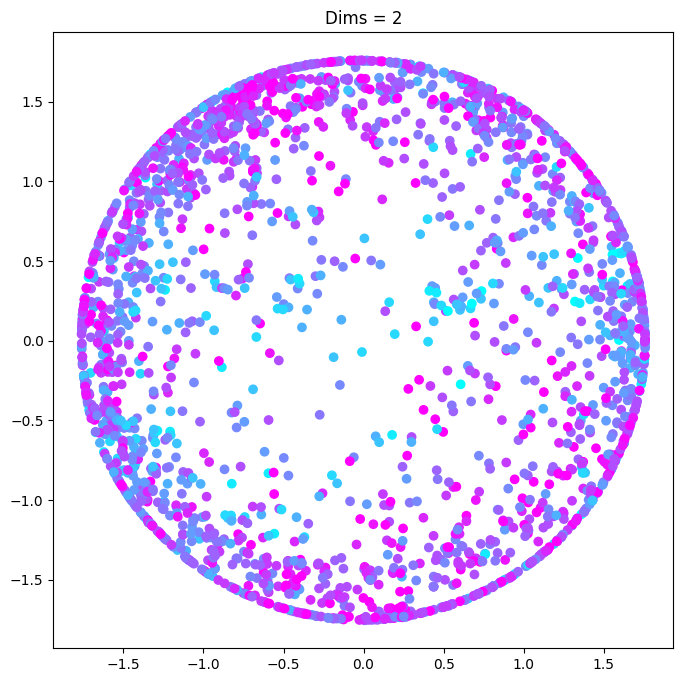

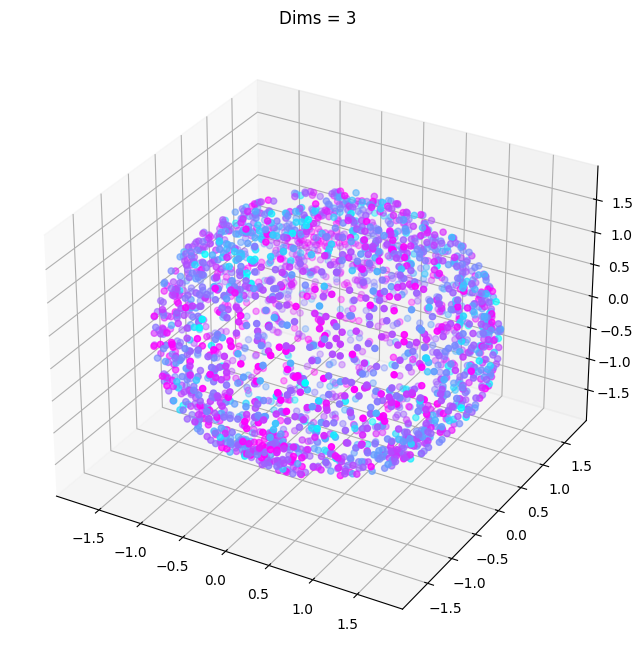

In [158]:
weights_2d = models[0].weight.tensor.detach().numpy().T

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
ax.scatter(*weights_2d, c=arc['heavy_atom_count'].clip(*color_clip), cmap=plt.cm.cool)

ax.set_title(f'Dims = 2')
plt.show()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(*models[1].weight.tensor.detach().numpy().T, c=arc['heavy_atom_count'].clip(*color_clip), cmap=plt.cm.cool)

ax.set_title(f'Dims = 3')
plt.show()

In [137]:
import itertools

0 1 2 (1472,)
0 2 1 (1401,)
1 2 0 (1490,)


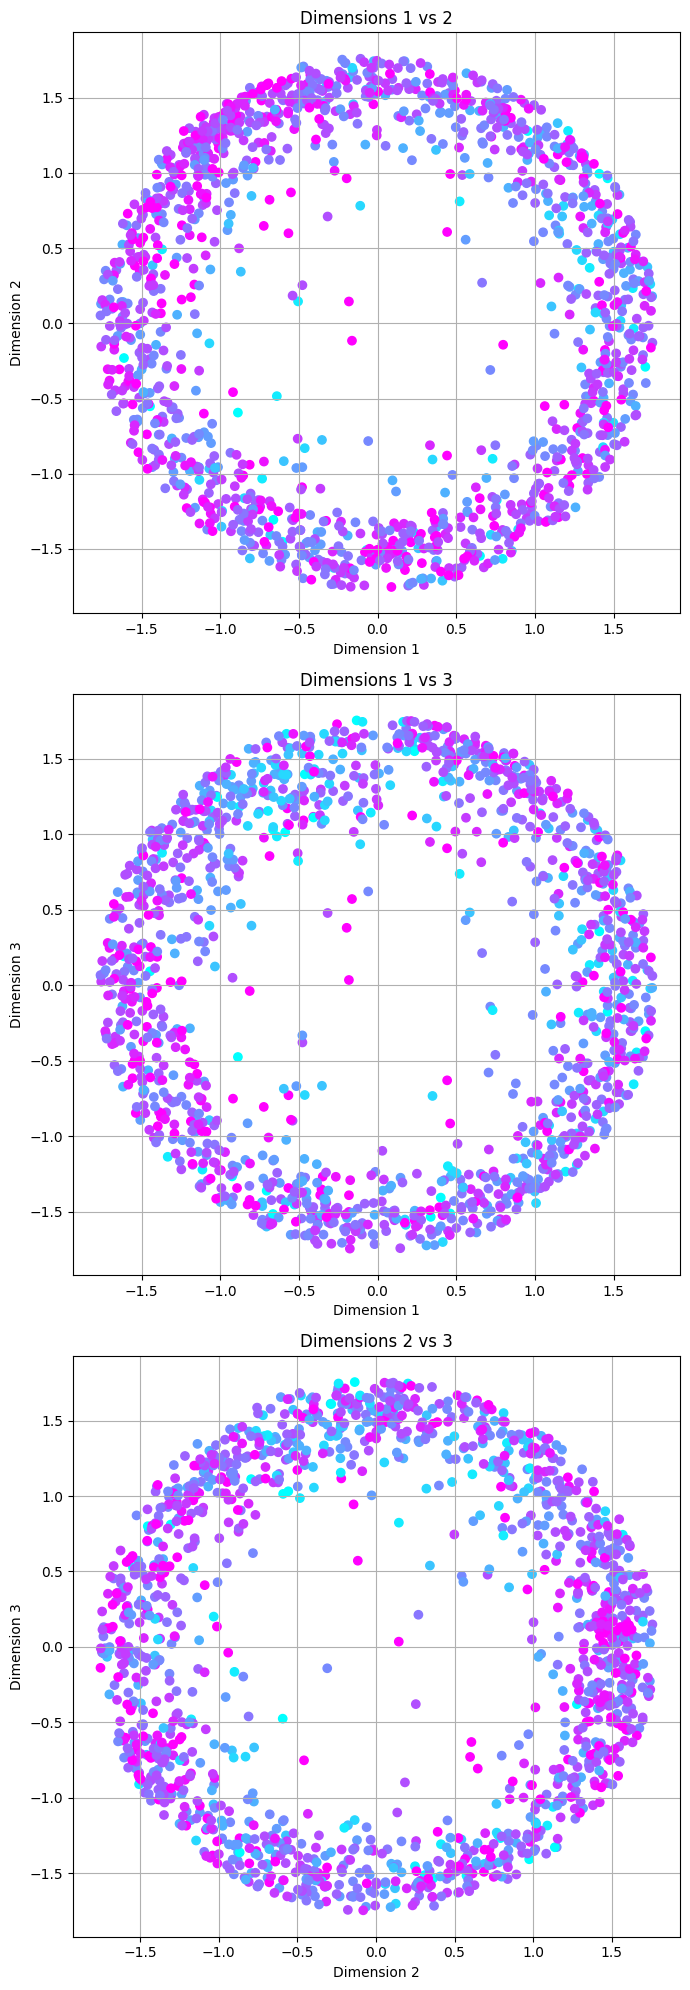

In [160]:
# Get the weight tensor of the second model
weights_3d = models[1].weight.tensor.detach().numpy().T

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(7, 20))

# Plot each combination of dimensions
for i, dims in enumerate(list(itertools.combinations(range(0, 3), 2))):
    ax = axes[i]
    dim1, dim2 = dims

    # filtered_indices = np.where((weights_3d[3 - dim1 - dim2] > -0.2) & (weights_3d[3 - dim1 - dim2] < 0.2))[0]
    filtered_indices = np.where(abs((weights_3d[3 - dim1 - dim2])) < 1)[0]
    print(dim1, dim2, 3 - dim1 - dim2, filtered_indices.shape)

    ax.scatter(weights_3d[dim1][filtered_indices], weights_3d[dim2][filtered_indices], c=np.array(arc['heavy_atom_count'].clip(*color_clip))[filtered_indices], cmap=plt.cm.cool)
    ax.set_title(f'Dimensions {dim1+1} vs {dim2+1}')
    ax.set_xlabel(f'Dimension {dim1+1}')
    ax.set_ylabel(f'Dimension {dim2+1}')
    ax.grid(True)

plt.tight_layout()
plt.show()


In [169]:
for i, d in enumerate(dims):
    for j in range(len(saved_weights[i])):
        weights_nd = saved_weights[i][j].tensor.detach().numpy().T
        corr = arc['heavy_atom_count'].corr(pd.Series(np.sqrt(sum([w**2 for w in weights_nd]))))
        print(f'{d}-D save-{j} corr(nHeavyAtom, |vec|) = {corr}')

1-D save-0 corr(nHeavyAtom, |vec|) = 0.4386799894534411
1-D save-1 corr(nHeavyAtom, |vec|) = 0.4386799894534411
1-D save-2 corr(nHeavyAtom, |vec|) = 0.4386799894534411
1-D save-3 corr(nHeavyAtom, |vec|) = 0.4386799894534411
1-D save-4 corr(nHeavyAtom, |vec|) = 0.4386799894534411
1-D save-5 corr(nHeavyAtom, |vec|) = 0.4386799894534411
1-D save-6 corr(nHeavyAtom, |vec|) = 0.4386799894534411
1-D save-7 corr(nHeavyAtom, |vec|) = 0.4386799894534411
1-D save-8 corr(nHeavyAtom, |vec|) = 0.4386799894534411
1-D save-9 corr(nHeavyAtom, |vec|) = 0.4386799894534411
2-D save-0 corr(nHeavyAtom, |vec|) = 0.28673005529570506
2-D save-1 corr(nHeavyAtom, |vec|) = 0.28673005529570506
2-D save-2 corr(nHeavyAtom, |vec|) = 0.28673005529570506
2-D save-3 corr(nHeavyAtom, |vec|) = 0.28673005529570506
2-D save-4 corr(nHeavyAtom, |vec|) = 0.28673005529570506
2-D save-5 corr(nHeavyAtom, |vec|) = 0.28673005529570506
2-D save-6 corr(nHeavyAtom, |vec|) = 0.28673005529570506
2-D save-7 corr(nHeavyAtom, |vec|) = 0.28

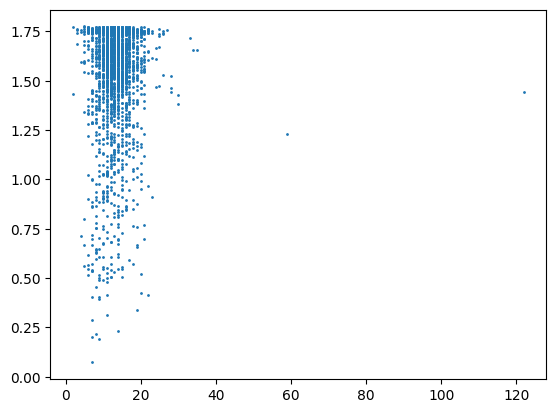

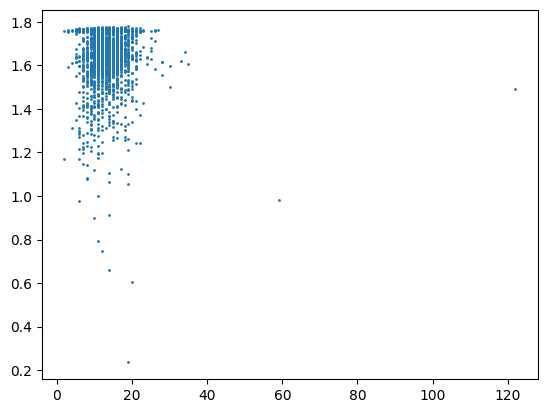

In [176]:
plt.scatter(arc['heavy_atom_count'], pd.Series(np.sqrt(sum([w**2 for w in weights_2d]))), s=1)
plt.show()
plt.scatter(arc['heavy_atom_count'], pd.Series(np.sqrt(sum([w**2 for w in weights_3d]))), s=1)
plt.show()